# Lorentz Booster
- Generate a whole bunch of particles moving at some relative velocity, then lorentz boost into their frame. This is done compactly by
$$
\bar{\eta}^\mu = \Lambda^\mu_\nu \eta^\nu
$$
where $\eta$ is the 

In [230]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import gaussian_kde
import scipy.stats as stats
%matplotlib inline

# my own little library for dealing with four vectors
import fourvectors as fv

In [231]:
### Constants
c = 3E8

### Create enums of particle properties, could be useful for multi-species experiments
class Proton(Enum):
    NAME   = "PROTON"
    MASS   = 1.672E-27 #kg
    CHARGE = 1.602E-19 #C

class Electron(Enum):
    NAME   = "ELECTRON"
    MASS   = 9.109E-21 #kg
    CHARGE =-1.602E-19 #C

class Reference(Enum):
    """A particle that is simply here to be a reference point."""
    NAME   = "REFERENCE PARTICLE"
    MASS   = 0        #kg
    CHARGE = 0        #C

In [232]:
### Create the particle class, this holds all of the nice info about each particle
class Particle():
    def __init__(
            self,
            species,
            pos0_3v = None,  # a three-position
            pos0_4v = None,  # a four-position
            v0_3v  = None,  # a three-velocity
            v0_4v  = None,  # a four-velocity
            frame  = "LAB"  # defaults to lab frame
        ):

        ### HANDLE INITIAL VELOCITIES

        # if no initial three-velocity specified, assume 0
        if v0_3v is None or v0_4v is None:
            v0_4v = np.array([0, 0, 0, 0])

        # if there is a 3v provided, convert it
        if v0_3v is not None:
            # otherwise set the four velocity to match it
            v0_4v = fv.to_four_velocity(v0_3v)

        ### HANDLE INITIAL POSITIONS

        # if no position specified, assume origin
        if pos0_3v is None or pos0_4v is None:
            pos0_4v = np.array([0, 0, 0, 0])

        # if there is a pos 3v provided, convert it
        if pos0_3v is not None:
            pos0_4v = fv.to_four_position(pos0_3v, 0)

        # Get the parameters from the species of particle
        self.name = species.NAME.value
        self.mass = species.MASS.value
        self.charge = species.CHARGE.value

        self.vel_4v = v0_4v    # four velocity
        self.pos_4v = pos0_4v  # four position
        self.frame  = frame

    ### Lorentz Boost Functionality
    def lorentz_boost_to(self, other):
        """Lorentz boost to another particle's frame"""
        # if the frame is lab, then we're boosting to another particle
        if self.frame == "LAB":
            self.frame = other.name
        else:
            self.frame = other.frame

        # first lorentz boost the velocity
        self.lorentz_boost_from_4v(other.vel_4v)

        # then shift it
        if self.name == "REFERENCE PARTICLE":
            # here, the particle is the reference, and becomes the new reference frame
            self.pos_4v = self.get_separation(other)
        else:
            # otherwise lorentz the separation vector given the velocity of the other
            # (likely the reference)
            self.pos_4v = np.linalg.matmul(
                    fv.lorentz_matrix_x_4v(other.vel_4v), self.get_separation(other)
                )

    def boost_as_reference(self):
        self.lorentz_boost_to(self)

    def lorentz_boost_from_4v(self, to_vel_4v):
        """Lorentz boost given a four-velocity"""
        lorentz_matrix = fv.lorentz_matrix_x_4v(to_vel_4v)
        self.vel_4v = np.linalg.matmul(lorentz_matrix, self.vel_4v)

    def lorentz_boost_from_3v(self, to_vel_3v):
        """Lorentz boost given a three-velocity"""
        self.lorentz_boost_from_4v(fv.to_four_velocity(to_vel_3v))

    def get_separation(self, other):
        """"get the separation vector between the two positions"""
        return self.pos_4v - other.pos_4v

    ### Getters
    def get_3v(self):
        return fv.to_three_velocity(self.vel_4v)

    def get_3p(self):
        return fv.to_three_position(self.pos_4v)

In [233]:
np.set_printoptions(formatter={'float': '{:.5e}'.format})

reference = Particle(Reference, v0_3v = np.array([2.9999E8, 0, 0]), pos0_3v=np.array([0,0,0]))
other_particle = Particle(Electron, v0_3v = np.array([2E8, 0, 0]), pos0_3v=np.array([1,50,0]))

print(f"--- {reference.frame} FRAME ---")
print(f"{reference.name} Velocity: {reference.get_3v()}")
print(f"{reference.name} Position: {reference.get_3p()[0]}")
print(f"{other_particle.name} Velocity: {other_particle.get_3v()}")
print(f"{other_particle.name} Position: {other_particle.get_3p()[0]}")

# perform the lorentz boost
other_particle.lorentz_boost_to(reference)
reference.boost_as_reference()

print(f"\n\n--- {reference.frame} FRAME ---")
print(f"{reference.name} Velocity: {reference.get_3v()}")
print(f"{reference.name} Position: {reference.get_3p()[0]}")
print(f"{other_particle.name} Velocity: {other_particle.get_3v()}")
print(f"{other_particle.name} Position: {other_particle.get_3p()[0]}")

--- LAB FRAME ---
REFERENCE PARTICLE Velocity: [[2.99990e+08 0.00000e+00 0.00000e+00]]
REFERENCE PARTICLE Position: [0.00000e+00 0.00000e+00 0.00000e+00]
ELECTRON Velocity: [[2.00000e+08 0.00000e+00 0.00000e+00]]
ELECTRON Position: [1.00000e+00 5.00000e+01 0.00000e+00]


--- REFERENCE PARTICLE FRAME ---
REFERENCE PARTICLE Velocity: [[0.00000e+00 0.00000e+00 0.00000e+00]]
REFERENCE PARTICLE Position: [0.00000e+00 0.00000e+00 0.00000e+00]
ELECTRON Velocity: [[-2.99950e+08 0.00000e+00 0.00000e+00]]
ELECTRON Position: [1.22476e+02 5.00000e+01 0.00000e+00]


# Bunch of particles exercise (1-D)
I'll assume 100 particles moving at a normally distributed velocity, just in the $\hat{x}$ direction to start. They will also only live on the $x$-axis.

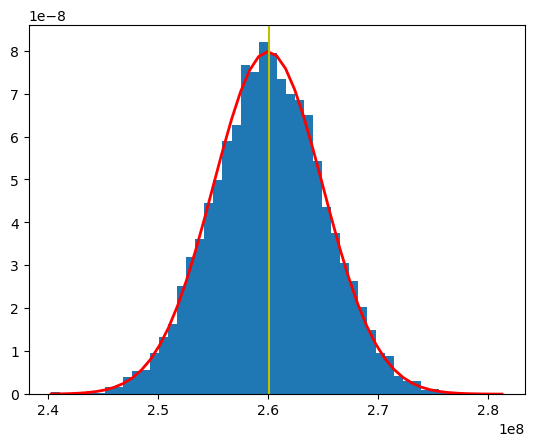

In [ ]:
# generate a sample of NUM_PARTICLES particles
NUM_PARTICLES = 10000
MU_VEL, SIGMA_VEL = 2.6E8, 5E6
MU_POS, SIGMA_POS = 0, 10

# create an array of NUM_PARTICLES Particle Objects with random velocities
particle_array = []

for i in range(NUM_PARTICLES):
    # i'm just going to do a whole bunch just going in the x direction
    # and give them a whole lot of positions
    particle_array.append(Particle(
        Electron,
        # could be risky, as the velocity can raise a ValueError
        # if it decides to go above c. its possible, but just
        # really improbable
        v0_3v=[np.random.normal(MU_VEL, SIGMA_VEL), 0, 0],
        pos0_3v=[np.random.normal(MU_POS, SIGMA_POS), 0 ,0]
        ))

def plotNormalWithLine(s, title=None):
    _, bins, _ = plt.hist(s, 50, density=True, label = title)
    plt.plot(bins, 1/(SIGMA_VEL * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - MU_VEL)**2 / (2 * SIGMA_VEL**2) ),
            linewidth=2, color='r')

def getBins1D(s):
    return np.histogram(s, bins=50, density=True) # histo, bin_edges

# get the velocities and positions of each particle
particle_vel = np.array([particle.get_3v() for particle in particle_array])
particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel = np.mean(particle_vel, axis=0)[0]
ref_pos = np.mean(particle_pos, axis=0)

# create reference particle
reference = Particle(Reference, v0_3v = ref_vel, pos0_3v = ref_pos)

# create a plot of the velocities, and the reference particle velocity marked with a yellow
plotNormalWithLine(norm(particle_vel, axis=2))
plt.axvline(x = norm(ref_vel), color = 'y', label = 'tiing')

Text(0.5, 1.0, 'Particle Positions (Before Lorentz Boost)')

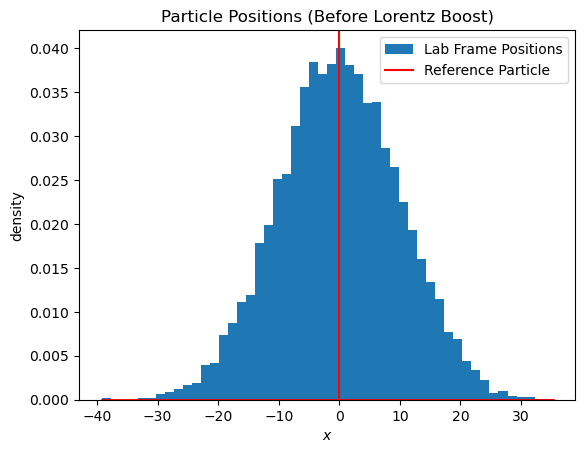

In [313]:
# but the more interesting plot is likely the positions
# i'll just start with printing the x plot

plt.xlabel("$x$")
plt.ylabel("density")
plotNormalWithLine(particle_pos[:,0], title="Lab Frame Positions")
plt.axvline(x = ref_pos[0], color='r', label = 'Reference Particle')
plt.legend()
plt.title("Particle Positions (Before Lorentz Boost)")

In [ ]:
# Perform the lorentz boost for each particle
for particle in particle_array:
    particle.lorentz_boost_to(reference)

reference.boost_as_reference()
# get the velocities and positions of each particle
particle_vel_boost = np.array([particle.get_3v() for particle in particle_array])
particle_pos_boost = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel_boost = np.mean(particle_vel, axis=0)[0]
ref_pos_boost = np.mean(particle_pos, axis=0)

Text(0.5, 1.0, 'Particle Position Comparison')

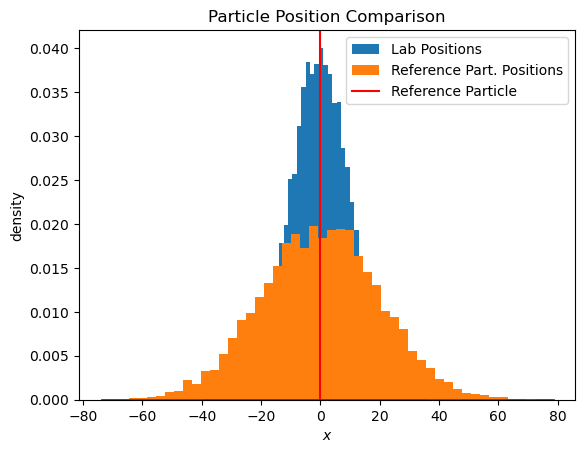

In [349]:
plt.xlabel("$x$")
plt.ylabel("density")
plotNormalWithLine(particle_pos[:,0], title="Lab Positions")
plotNormalWithLine(particle_pos_boost[:,0], title="Reference Part. Positions")
plt.axvline(x = ref_pos[0], color='r', label = 'Reference Particle')
plt.legend()
plt.title("Particle Position Comparison")

### Particle Binning Things
This is to get the charge density for use in Jefimenko's Equation

In [ ]:
# get the density in bin
lab_density, lab_bins = getBins1D(particle_pos[:,0])
ref_density, ref_bins = getBins1D(particle_pos_boost[:,0])

def evalChargeDensity1D(histo, bins, num_particles, species, val):
    """Evaluates the charge density in a bin given a point."""
    # clamp the number to be within the bin range
    val = np.clip(val, bins[0], bins[-1])

    # get the index of the left bin
    lower_index = int((val - bins[0])/(bins[1]-bins[0]))

    # get the total charge and multiply it by the density to get our value for rho
    return num_particles * species.CHARGE.value * histo[lower_index]

evalChargeDensity1D(lab_density, lab_bins, NUM_PARTICLES, Electron, 0)

np.float64(-6.414936904873294e-17)

## Jefimenko's Equation 1D Space Charge ver.
Let's now try to implement the Jefimenko's equation (only the space charge term) with my quadrature rules.

$$
\textbf{E} = \frac{1}{4\pi\epsilon_0} \int \frac{\rho(\textbf{r}', t_r)}{r^2}\hat{r} \, \text{dV}
$$
Because we are working in 1D, it becomes:

$$
E_x = \frac{1}{4\pi\epsilon_0} \int \frac{\rho(\textbf{r}', t_r)}{x^2}\hat{x} \, \text{dx}
$$

In [ ]:
###
# Quadrature Rules Definitions
###

from numpy.polynomial.legendre import leggauss

def linTransform(t, a, b):
    """Linear transformation for turning bounds from (a, b) to (-1, 1) to be used in Gaussian quadrature"""
    return 0.5 * ((b - a) * t + a + b)

### Gaussian Quadrature Implementation
def gaussQuad1D(f, a, b, n):
    """1-D Gaussian Quadrature using Legendre Polynomials"""

    roots, weights = leggauss(n)

    sum = 0
    # perform the summation
    for i in range(n):
        # do transformation to account for all ranges
        x = linTransform(roots[i], a, b)
        sum += weights[i] * f(x)

    # multiply by the coefficents from the variable substitution
    return 0.5 * (b - a) * sum

def gaussQuad2D(f, x_bounds, y_bounds, n):
    """2-D Gaussian Quadrature using Legendre Polynomials"""
    # unpack variables needed for algo
    roots, weights = leggauss(n)
    a,b = x_bounds
    c,d = y_bounds

    # perform the double summation as perscribed in a Gaussian Quad.
    sum = 0
    for i in range(n):
        # transform out of x
        u = linTransform(roots[i], a, b)
        for j in range(n):
            # transform out of y
            v = linTransform(roots[j], c, d)

            sum += weights[i] * weights[j] * f(u, v)

    # multiply by the extra coefficient needed from variable substitution
    return 0.25 * (b - a) * (d - c) * sum

def gaussQuad3D(fxn, x_bounds, y_bounds, z_bounds, n):
    """3-D Gaussian Quadrature using Legendre Polynomials"""
    # unpack variables needed for algo
    roots, weights = leggauss(n)
    a,b = x_bounds
    c,d = y_bounds
    e,f = z_bounds

    # perform the triple(!) summation as perscribed in a Gaussian Quad.
    sum = 0
    for i in range(n):
        # transform out of x
        u = linTransform(roots[i], a, b)

        for j in range(n):
            # transform out of y
            v = linTransform(roots[j], c, d)

            for k in range(n):
                #transform out of z
                w = linTransform(roots[k], e, f)
                sum += weights[i] * weights[j] * weights[k] * fxn(u, v, w)

    # multiply by the coefficients due to the variable transforms
    return 0.125 * (b - a) * (c - d) * (e - f) * sum

In [366]:
def jefimenko1D(histo, bins, val):
    """Finds the e-field at a point using 1D Jefimenko's equation space charge term."""
       # clamp the number to be within the bin range
    val = np.clip(val, bins[0], bins[-1])

    # get the index of the left bin this is for direction of efld
    lower_index = int((val - bins[0])/(bins[1]-bins[0]))

    # i can be a bit sneaky here and pull the rho out of the integral
    return np.sign(bins[lower_index]) * gaussQuad1D(lambda x: val**-2, bins[0], bins[-1], 4)\
           * evalChargeDensity1D(histo, bins, NUM_PARTICLES, Electron, val)\
                /(4 * np.pi * 8.85E-12)

In [ ]:
# evalute the jefimenko's equation at each point on my mesh
eflds = []
for pos in particle_pos_boost:
    eflds.append(jefimenko1D(ref_density, ref_bins, pos[0]))

[np.float64(-9.726153356560347e-07), np.float64(-5.511566043678008e-07), np.float64(4.100401458090447e-08), np.float64(1.1332337281566193e-06), np.float64(-3.374571855307375e-07), np.float64(-1.3675749877452364e-08), np.float64(-8.824465428574154e-07), np.float64(1.3210839700249678e-07), np.float64(-1.3344373455929863e-06), np.float64(-6.024666397060541e-07), np.float64(-2.3310722333205993e-08), np.float64(0.00016041839319056215), np.float64(-1.407881097992746e-07), np.float64(-2.8018132424233746e-06), np.float64(6.356895839224869e-08), np.float64(-1.8873157734924283e-07), np.float64(3.674877296519543e-06), np.float64(4.008071663649332e-06), np.float64(-4.7026372855456776e-08), np.float64(9.909363921416627e-07), np.float64(-6.93909656985921e-07), np.float64(4.500789615667946e-09), np.float64(-6.988387468004614e-07), np.float64(6.428053580655757e-06), np.float64(5.858872143661987e-09), np.float64(1.1327944111628647e-07), np.float64(1.9410267219585514e-07), np.float64(-4.542274692813884e

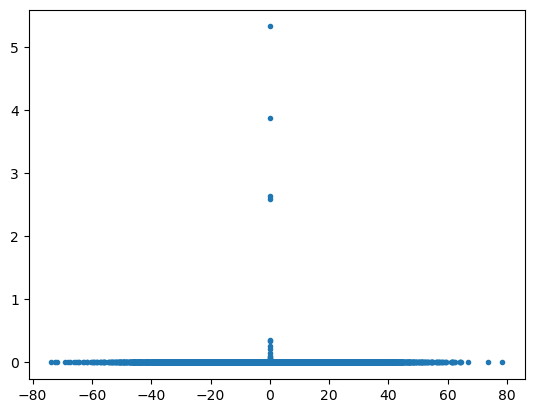

In [ ]:
# I'll plot the efld vs the particle position at the point
plt.plot(particle_pos_boost[:,0], eflds, '.')

That isn't what I expected it to look like ngl

## Some notes
- This is super hard-coded(i.e. only electrons, and clunky global number of particles), so I'll need to make a few changes before I code myself into a corner.